In [86]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
pd.set_option('display.max_columns', 500)
import os.path
from loguru import logger
import seaborn as sns
import plotly.graph_objects as go
import datetime
import vaex
import warnings
warnings.filterwarnings("ignore")
from scipy.optimize import minimize
from scipy.optimize import least_squares
from sklearn.linear_model import LinearRegression


## Preloaded data

In [3]:
df = pd.read_csv(f"./datasets/deribit_options_chain_2022-12-01_OPTIONS.csv")


In [4]:
df.head()

,exchange,symbol,timestamp,local_timestamp,type,strike_price,expiration,open_interest,last_price,bid_price,bid_amount,bid_iv,ask_price,ask_amount,ask_iv,mark_price,mark_iv,underlying_index,underlying_price,delta,gamma,vega,theta,rho
0,deribit,ETH-9DEC22-1400-C,1669852800002000,1669852800011631,call,1400,1670572800000000,12888.0,0.0145,0.0140,309.0,68.60,0.0150,230.0,70.70,0.0146,69.75,ETH-9DEC22,1294.5900,0.24508,0.00230,0.61504,-2.57385,0.06814
1,deribit,ETH-16DEC22-1300-P,1669852800011000,1669852800014218,put,1300,1671177600000000,185.0,0.0640,0.0630,127.0,74.35,0.0650,214.0,76.80,0.0632,74.51,SYN.ETH-16DEC22,1294.5233,-0.48057,0.00202,1.05725,-2.56887,-0.29568
2,deribit,ETH-16DEC22-1500-C,1669852800010000,1669852800017777,call,1500,1671177600000000,7503.0,0.0150,0.0135,426.0,72.46,0.0145,219.0,74.30,0.0140,73.44,SYN.ETH-16DEC22,1294.5233,0.18313,0.00136,0.70376,-1.68530,0.09196
3,deribit,ETH-30DEC22-1400-P,1669852800013000,1669852800018794,put,1400,1672387200000000,11013.0,0.1275,0.1310,101.0,71.44,0.1335,83.0,73.73,0.1325,72.78,ETH-30DEC22,1294.2700,-0.60928,0.00144,1.40850,-1.74735,-0.77151
4,deribit,ETH-2DEC22-1300-C,1669852800013000,1669852800019006,call,1300,1669968000000000,26858.0,0.0145,0.0140,32.0,66.44,0.0150,85.0,70.60,0.0147,69.18,ETH-2DEC22,1294.4500,0.46756,0.00735,0.31108,-8.07055,0.02142


## LinReg

In [113]:
data

,timestamp,type,strike_price,expiration,open_interest,last_price,bid_price,bid_amount,bid_iv,ask_price,ask_amount,ask_iv,mark_price,mark_iv,underlying_price
0,1669852800002000,call,1400,1670572800000000,12888.0,0.0145,0.0140,309.0,68.60,0.0150,230.0,70.70,0.0146,69.75,1294.59
1,1669852800013000,put,1400,1672387200000000,11013.0,0.1275,0.1310,101.0,71.44,0.1335,83.0,73.73,0.1325,72.78,1294.27
2,1669852800013000,call,1300,1669968000000000,26858.0,0.0145,0.0140,32.0,66.44,0.0150,85.0,70.60,0.0147,69.18,1294.45
3,1669852800014000,call,1300,1680249600000000,3699.0,0.1660,0.1705,5.0,76.67,0.1725,46.0,77.56,0.1715,77.12,1288.31
4,1669852800015000,put,1300,1674806400000000,1251.0,0.1210,0.1215,65.0,75.01,0.1240,257.0,76.61,0.1224,75.61,1292.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8509952,1669939199491000,call,2200,1688112000000000,20159.0,0.0690,0.0630,25.0,73.89,0.0680,56.0,75.96,0.0653,74.85,1274.47
8509953,1669939199500000,call,1200,1674806400000000,5810.0,0.1455,0.1485,44.0,77.20,0.1500,26.0,78.22,0.1492,77.65,1274.44
8509954,1669939199492000,put,20000,1680249600000000,5.0,15.0000,NaN,NaN,NaN,NaN,NaN,NaN,14.7163,129.03,1272.52
8509955,1669939199500000,put,1100,1674806400000000,4012.0,0.0605,0.0620,259.0,81.33,0.0630,40.0,82.10,0.0625,81.75,1274.44


In [112]:
currency = "ETH"
ind = [symbol.startswith(currency) for symbol in linreg.underlying_index]
columns_to_drop = ['exchange', 'symbol', 'local_timestamp', 'underlying_index', 
                       'delta', 'gamma', 'vega', 'theta', 'rho']
data = linreg[ind].reset_index(drop=True).drop(columns_to_drop, axis=1)
# data = data[["underlying_price", "mark_iv"]].drop_duplicates()

In [81]:
data["ln_underlying_price"] = np.log(data["underlying_price"])
data["ln_mark_iv"] = np.log(data["mark_iv"])

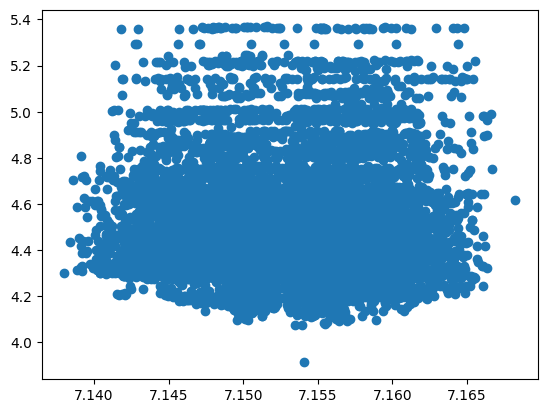

In [85]:
test = data.sample(10000)
plt.scatter(test["ln_underlying_price"], test["ln_mark_iv"])

In [106]:
lr = LinearRegression()
lr.fit(data["ln_underlying_price"].values.reshape(-1, 1), data["ln_mark_iv"])

LinearRegression()

In [110]:
lr.coef_

array([0.36249704])

In [109]:
lr.set_params()

LinearRegression()

In [150]:
df.symbol.value_counts()

ETH-30JUN23-1500-P     205703
ETH-30JUN23-1300-P     140147
ETH-30JUN23-1200-P      80955
BTC-30DEC22-19000-P     53613
ETH-24FEB23-1400-P      46351
                        ...  
ETH-1DEC22-1000-P        5110
BTC-1DEC22-17500-P       5035
ETH-1DEC22-1125-P        4993
ETH-1DEC22-1100-P        4836
ETH-1DEC22-1075-P        4822
Name: symbol, Length: 1326, dtype: int64

In [149]:
df

,exchange,symbol,timestamp,local_timestamp,type,strike_price,expiration,open_interest,last_price,bid_price,bid_amount,bid_iv,ask_price,ask_amount,ask_iv,mark_price,mark_iv,underlying_index,underlying_price,delta,gamma,vega,theta,rho
0,deribit,ETH-9DEC22-1400-C,1669852800002000,1669852800011631,call,1400,1670572800000000,12888.0,0.0145,0.0140,309.0,68.60,0.0150,230.0,70.70,0.0146,69.75,ETH-9DEC22,1294.5900,0.24508,0.00230,0.61504,-2.57385,0.06814
1,deribit,ETH-16DEC22-1300-P,1669852800011000,1669852800014218,put,1300,1671177600000000,185.0,0.0640,0.0630,127.0,74.35,0.0650,214.0,76.80,0.0632,74.51,SYN.ETH-16DEC22,1294.5233,-0.48057,0.00202,1.05725,-2.56887,-0.29568
2,deribit,ETH-16DEC22-1500-C,1669852800010000,1669852800017777,call,1500,1671177600000000,7503.0,0.0150,0.0135,426.0,72.46,0.0145,219.0,74.30,0.0140,73.44,SYN.ETH-16DEC22,1294.5233,0.18313,0.00136,0.70376,-1.68530,0.09196
3,deribit,ETH-30DEC22-1400-P,1669852800013000,1669852800018794,put,1400,1672387200000000,11013.0,0.1275,0.1310,101.0,71.44,0.1335,83.0,73.73,0.1325,72.78,ETH-30DEC22,1294.2700,-0.60928,0.00144,1.40850,-1.74735,-0.77151
4,deribit,ETH-2DEC22-1300-C,1669852800013000,1669852800019006,call,1300,1669968000000000,26858.0,0.0145,0.0140,32.0,66.44,0.0150,85.0,70.60,0.0147,69.18,ETH-2DEC22,1294.4500,0.46756,0.00735,0.31108,-8.07055,0.02142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22492236,deribit,BTC-30DEC22-34000-C,1669939199983000,1669939199999665,call,34000,1672387200000000,3670.1,0.0005,NaN,NaN,NaN,0.0005,0.1,95.08,0.0004,93.19,BTC-30DEC22,16953.1600,0.00538,0.00000,0.72864,-1.19821,0.06533
22492237,deribit,BTC-29SEP23-10000-C,1669939199983000,1669939199999801,call,10000,1695974400000000,0.6,0.4775,0.4650,10.1,70.33,0.4915,10.0,83.81,0.4728,74.39,BTC-29SEP23,16962.0900,0.86858,0.00002,32.84842,-4.05454,55.42993
22492238,deribit,BTC-31MAR23-5000-C,1669939199984000,1669939199999808,call,5000,1680249600000000,2.7,0.7390,0.7005,12.0,NaN,0.7120,12.0,126.49,0.7089,113.66,BTC-31MAR23,16946.2200,0.98621,0.00000,3.41384,-1.62576,15.36320
22492239,deribit,BTC-9DEC22-13500-C,1669939199988000,1669939199999809,call,13500,1670572800000000,0.0,NaN,0.0005,0.3,NaN,NaN,NaN,NaN,0.2059,84.57,BTC-9DEC22,16975.1700,0.97563,0.00003,1.37670,-7.93844,2.62528


In [162]:
def select_data(df: pd.DataFrame, currency: str  = "BTC"):
    # take single currency
    ind = [symbol.startswith(currency) for symbol in df.symbol]
    columns_to_drop = ['exchange', 'symbol', 'local_timestamp', 'underlying_index', 
                       'delta', 'gamma', 'vega', 'theta', 'rho']
    
    data = df[ind].reset_index(drop=True).drop(columns_to_drop, axis=1)

    #tau is time before expiration in years
    data['tau'] = (data.expiration - data.timestamp) / 1e6 / 3600 / 24 / 365
    #days before exp
    data['days'] = (data['tau'] * 365).astype(int)
    
    
    # find beta for each expiration
    
    data["human_expiration"] = data["expiration"]\
    .apply(lambda x : datetime.datetime.fromtimestamp(x/1000000.0).strftime('%Y-%m-%d %H:%M:%S.%f'))

    K = data.strike_price.values
    F = data.underlying_price.values

    payoff = np.maximum(F - K, 0.0)
    payoff[data.type == 'put'] = np.maximum( K - F, 0.0)[data.type == 'put']
    data["payoff"] = payoff
    
    #inverse 
    data["inverse_payoff"] =  data["payoff"]/data["underlying_price"]
    
    data['mid_price'] = 0.5 * (data.ask_price + data.bid_price)
    
    data_grouped = data.groupby(['type', 'expiration', 'strike_price'])\
    .agg(lambda x: x.iloc[-1]).reset_index().drop(["timestamp"], axis=1)

    # отбираем тольеко не истекшие
    put = data_grouped[data_grouped.type == 'put'].drop(['type'], axis=1).reset_index(drop=True)
    put = put[put["days"] > 0] 
    
    call = data_grouped[data_grouped.type == 'call'].drop(['type'], axis=1).reset_index(drop=True)
    call = call[call["days"] > 0] 
    
    return put, call

In [163]:
put, call = select_data(df, currency="ETH")


In [173]:
days = sorted(list(set(call.days.values)))
print(f"Expiration dates: {days}") 

Expiration dates: [1, 7, 14, 21, 28, 56, 84, 119, 210, 301]


In [182]:
call

,expiration,strike_price,open_interest,last_price,bid_price,bid_amount,bid_iv,ask_price,ask_amount,ask_iv,mark_price,mark_iv,underlying_price,tau,days,human_expiration,payoff,inverse_payoff,mid_price
47,1670054400000000,600,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5298,120.00,1276.1586,0.003653,1,2022-12-03 11:00:00.000000,676.1586,0.529839,NaN
48,1670054400000000,700,0.0,NaN,0.0005,2.0,NaN,NaN,NaN,NaN,0.4515,120.00,1276.1586,0.003653,1,2022-12-03 11:00:00.000000,576.1586,0.451479,NaN
49,1670054400000000,800,0.0,NaN,0.0005,2.0,NaN,NaN,NaN,NaN,0.3731,120.00,1276.1586,0.003653,1,2022-12-03 11:00:00.000000,476.1586,0.373119,NaN
50,1670054400000000,900,0.0,NaN,0.0005,2.0,NaN,NaN,NaN,NaN,0.2948,120.00,1276.1586,0.003653,1,2022-12-03 11:00:00.000000,376.1586,0.294759,NaN
51,1670054400000000,1000,0.0,NaN,0.0005,2.0,NaN,NaN,NaN,NaN,0.2164,120.00,1276.1586,0.003653,1,2022-12-03 11:00:00.000000,276.1586,0.216398,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,1695974400000000,3500,823.0,0.045,0.0430,1.0,80.00,0.0465,46.0,81.61,0.0448,80.82,1273.1800,0.825571,301,2023-09-29 11:00:00.000000,0.0000,0.000000,0.04475
320,1695974400000000,4000,437.0,0.036,0.0335,1.0,81.81,0.0380,48.0,84.19,0.0357,83.02,1273.1800,0.825571,301,2023-09-29 11:00:00.000000,0.0000,0.000000,0.03575
321,1695974400000000,4500,369.0,0.026,0.0290,1.0,84.76,0.0315,50.0,86.24,0.0303,85.51,1273.1800,0.825571,301,2023-09-29 11:00:00.000000,0.0000,0.000000,0.03025
322,1695974400000000,5000,2193.0,0.022,0.0235,1.0,85.93,0.0280,50.0,88.91,0.0257,87.44,1273.1800,0.825571,301,2023-09-29 11:00:00.000000,0.0000,0.000000,0.02575


In [224]:
single_expiration = single_expiration[["symbol", "timestamp", "type", "strike_price", 
                                       "expiration", "mark_price", "mark_iv", "underlying_price"]]
single_expiration = single_expiration[single_expiration["expiration"] == single_expiration.sample(1).iloc[0].expiration]


In [245]:
single_expiration_test = single_expiration[single_expiration["symbol"]==single_expiration.sample(1).iloc[0].symbol]

In [246]:
single_expiration_test.timestamp.max()

1669939194959000

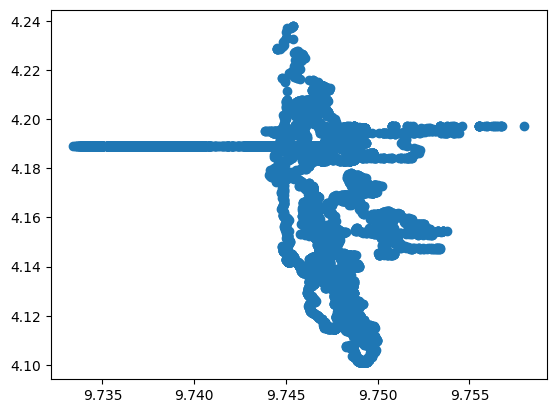

In [250]:
plt.scatter(np.log(single_expiration_test["underlying_price"]), np.log(single_expiration_test["mark_iv"]))

In [248]:
single_expiration_test

,symbol,timestamp,type,strike_price,expiration,mark_price,mark_iv,underlying_price
84,BTC-2DEC22-18000-C,1669852801217000,call,18000,1669968000000000,0.002,63.13,17158.62
213,BTC-2DEC22-18000-C,1669852802123000,call,18000,1669968000000000,0.002,63.13,17159.14
1091,BTC-2DEC22-18000-C,1669852804210000,call,18000,1669968000000000,0.002,63.13,17158.56
1236,BTC-2DEC22-18000-C,1669852804474000,call,18000,1669968000000000,0.002,63.13,17158.53
1324,BTC-2DEC22-18000-C,1669852805247000,call,18000,1669968000000000,0.002,63.13,17158.53
...,...,...,...,...,...,...,...,...
22486388,BTC-2DEC22-18000-C,1669939174818000,call,18000,1669968000000000,0.000,65.97,16968.47
22487294,BTC-2DEC22-18000-C,1669939179847000,call,18000,1669968000000000,0.000,65.97,16968.82
22488307,BTC-2DEC22-18000-C,1669939184879000,call,18000,1669968000000000,0.000,65.97,16971.66
22489794,BTC-2DEC22-18000-C,1669939189922000,call,18000,1669968000000000,0.000,65.97,16972.04


In [217]:
# single_expiration["diff_between_f_and_strike"] = single_expiration["underlying_price"] - single_expiration["strike_price"] 
# single_expiration_min = single_expiration[single_expiration["diff_between_f_and_strike"]>=0].diff_between_f_and_strike.min()
# single_expiration_max = single_expiration[single_expiration["diff_between_f_and_strike"]<=0].diff_between_f_and_strike.max()
# single_expiration_closest_strikes = single_expiration[
#     (single_expiration["diff_between_f_and_strike"] == single_expiration_min) |
#     (single_expiration["diff_between_f_and_strike"] == - single_expiration_max) 
# ]


<AxesSubplot: >

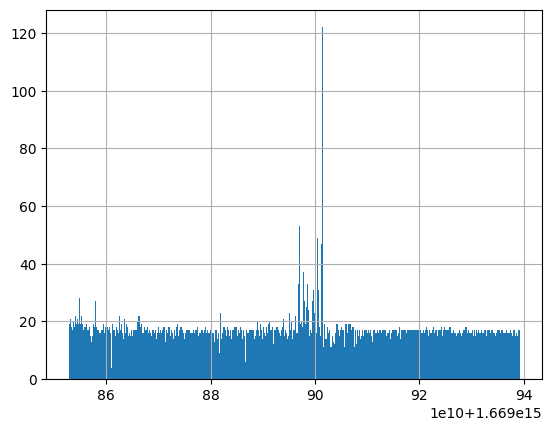

In [247]:
single_expiration_test["timestamp"].hist(bins = 1000)

In [233]:
single_expiration[single_expiration["symbol"]=="BTC-30JUN23-17000-C"]

,symbol,timestamp,type,strike_price,expiration,mark_price,mark_iv,underlying_price


In [221]:
single_expiration_closest_strikes

,exchange,symbol,timestamp,local_timestamp,type,strike_price,expiration,open_interest,last_price,bid_price,bid_amount,bid_iv,ask_price,ask_amount,ask_iv,mark_price,mark_iv,underlying_index,underlying_price,delta,gamma,vega,theta,rho,diff_between_f_and_strike
12534144,deribit,ETH-2DEC22-1275-P,1669902543510000,1669902543517125,put,1275,1669968000000000,496.0,0.0120,0.0115,30.0,63.27,0.0125,45.0,68.78,0.0121,66.93,ETH-2DEC22,1275.0,-0.49392,0.01026,0.23172,-7.75441,-0.01339,0.0
12534350,deribit,ETH-2DEC22-1275-C,1669902543895000,1669902543905223,call,1275,1669968000000000,565.0,0.0120,0.0115,220.0,63.27,0.0130,207.0,71.53,0.0122,66.93,ETH-2DEC22,1275.0,0.50608,0.01026,0.23172,-7.75441,0.01307,0.0
12894468,deribit,ETH-2DEC22-1275-C,1669903488553000,1669903488561094,call,1275,1669968000000000,566.0,0.0135,0.0110,283.0,60.97,0.0125,216.0,69.29,0.0118,65.34,ETH-2DEC22,1275.0,0.50589,0.01059,0.23001,-7.51460,0.01288,0.0
12894477,deribit,ETH-2DEC22-1275-C,1669903488559000,1669903488567953,call,1275,1669968000000000,566.0,0.0135,0.0110,283.0,60.97,0.0125,222.0,69.29,0.0118,65.34,ETH-2DEC22,1275.0,0.50589,0.01059,0.23001,-7.51460,0.01288,0.0
12894580,deribit,ETH-2DEC22-1275-C,1669903489057000,1669903489065691,call,1275,1669968000000000,566.0,0.0135,0.0110,283.0,60.97,0.0125,216.0,69.29,0.0118,65.34,ETH-2DEC22,1275.0,0.50589,0.01059,0.23001,-7.51460,0.01288,0.0
12894675,deribit,ETH-2DEC22-1275-C,1669903489807000,1669903489816742,call,1275,1669968000000000,566.0,0.0135,0.0110,283.0,60.97,0.0125,222.0,69.29,0.0118,65.34,ETH-2DEC22,1275.0,0.50589,0.01059,0.23001,-7.51460,0.01288,0.0
12896017,deribit,ETH-2DEC22-1275-C,1669903493321000,1669903493335702,call,1275,1669968000000000,566.0,0.0135,0.0110,274.0,60.97,0.0125,222.0,69.29,0.0118,65.45,ETH-2DEC22,1275.0,0.50590,0.01057,0.23001,-7.52763,0.01288,0.0
12896023,deribit,ETH-2DEC22-1275-C,1669903493329000,1669903493342054,call,1275,1669968000000000,566.0,0.0135,0.0110,204.0,60.97,0.0125,222.0,69.29,0.0118,65.45,ETH-2DEC22,1275.0,0.50590,0.01057,0.23001,-7.52763,0.01288,0.0
12896062,deribit,ETH-2DEC22-1275-C,1669903493372000,1669903493380016,call,1275,1669968000000000,566.0,0.0135,0.0110,204.0,60.97,0.0125,235.0,69.29,0.0118,65.45,ETH-2DEC22,1275.0,0.50590,0.01057,0.23001,-7.52763,0.01288,0.0
12896124,deribit,ETH-2DEC22-1275-C,1669903493540000,1669903493556700,call,1275,1669968000000000,566.0,0.0135,0.0110,199.0,60.97,0.0125,235.0,69.29,0.0118,65.45,ETH-2DEC22,1275.0,0.50590,0.01057,0.23001,-7.52763,0.01288,0.0


# Калибровка

In [175]:
class SABR:
    def __init__(self, data: pd.DataFrame) -> None:
        """Class to model the volatility smile"""
        self.data = data
        # let it be fixed as in the artice
        self.beta = 0.5
        self.T = data.iloc[0].tau
        #Change by milliseconds, but we need similar
        self.underlying_price = data.iloc[0].underlying_price
        # start params for optimization
        self.x0 = np.array([0.99, 0.00, 0.99])
        self.bounds = [(0.0001, 1000.0), (-0.9999, 0.9999), (0.0001, 1000.0)]


    def _sigmaB(
        self, f: float, K: float, T: float, alpha: float, rho: float, v: float
    ) -> float:
        """Function to count modeled volatility"""
        first_part_of_numerator = (
            (1 - self.beta) ** 2 / 24 * alpha**2 / (f * K) ** (1 - self.beta)
        )
        second_part_of_numerator = (
            (rho * self.beta * v * alpha) / 4 * (f * K) ** ((1 - self.beta) / 2)
        )
        third_part_of_numerator = (2 - 3 * rho**2) * v**2 / 24
        numerator = alpha * (
            1
            + self.T
            * (
                first_part_of_numerator
                + second_part_of_numerator
                + third_part_of_numerator
            )
        )

        first_part_of_denominator = (1 - self.beta) ** 2 / 24 * (np.log(f / K)) ** 2
        second_part_of_denominator = (1 - self.beta) ** 4 / 1920 * (np.log(f / K)) ** 4
        denominator = (f * K) ** ((1 - self.beta) / 2) * (
            1 + first_part_of_denominator + second_part_of_denominator
        )

        z = v / alpha * (f * K) ** ((1 - self.beta) / 2) * np.log(f / K)

        xi = np.log((np.sqrt(1 - 2 * rho * z + z**2) + z - rho) / (1 - rho))

        return numerator / denominator * z / xi

    def _plot_results(self) -> None:
        """Function to plot results"""

        def get_sigmas_for_set_of_params(alpha: float, rho: float, v: float) -> None:
            """Inner function to count sigmas for current optimization method"""
            self.volatilities = []
            self.test_strikes = np.linspace(500, 5000, 100)
            for strike in self.test_strikes:
                sigma_modeled = self._sigmaB(
                    self.underlying_price, strike, self.T, alpha, rho, v
                )
                self.volatilities.append(sigma_modeled)

        get_sigmas_for_set_of_params(
            self.alpha_scipy, self.rho_scipy, self.v_scipy
        )

        fig, ax = plt.subplots(figsize=(20, 7))
        ax = sns.scatterplot(x = "strike_price", y = "mark_iv", data=self.data, 
                             color = "black",
                             label="scipy optimizer")

        ax1 = sns.lineplot(
            x=self.test_strikes,
            y=self.volatilities,
            label="market volatilities",
            color="blue",
        ).set_title(f"T = {int(self.T * 365)} days")

    def _vol_square_error(self, x: np.ndarray) -> np.float64:
        """Function to get the argmin function we want to optimize"""
        # init market volatiliteis
        smile = self.data.mark_iv.to_numpy()
        vols = []
        for index, row in self.data.iterrows():
            vols.append(
                self._sigmaB(
                    self.underlying_price, row["strike_price"], self.T, x[0], x[1], x[2]
                )
            )
        return sum((vols - smile) ** 2)


    def _minimize_scipy(self) -> np.float64:
        """Optimization with scipy optimizer"""
        return minimize(self._vol_square_error, x0=self.x0,  bounds = self.bounds)

    def run(self) -> None:
        """Run optimization and plot results"""
        # optimization via scipy
        optimum_scipy = self._minimize_scipy()
        self.alpha_scipy, self.rho_scipy, self.v_scipy = optimum_scipy.x
        logger.info(
            f"Optimal params for T = {int(self.T*365)} days: alpha = {self.alpha_scipy}, rho = {self.rho_scipy}, v = {self.v_scipy}"
        )
        # plot market values and modeled function
        self._plot_results()
        return self.volatilities, self.alpha_scipy, self.beta, self.rho_scipy, self.v_scipy, self.T


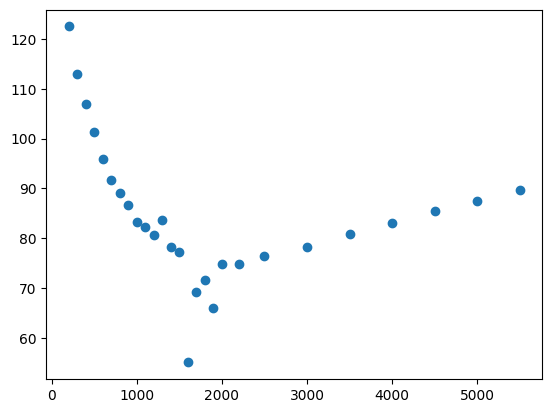

In [176]:
plt.scatter(put_["strike_price"], put_["mark_iv"])


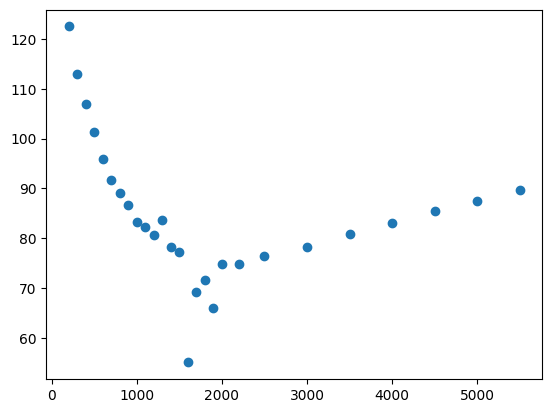

In [135]:
plt.scatter(call_["strike_price"], call_["mark_iv"])


2022-12-11 21:52:11.293 | INFO     | __main__:run:100 - Optimal params for T = 1 days: alpha = 276.3329140381431, rho = 0.04651687584253231, v = 42.37956131654851
2022-12-11 21:52:11.613 | INFO     | __main__:run:100 - Optimal params for T = 7 days: alpha = 272.7405544221619, rho = -0.0014731528476978806, v = 77.56176143881333
2022-12-11 21:52:11.910 | INFO     | __main__:run:100 - Optimal params for T = 14 days: alpha = 347.44237830392996, rho = -0.0009302197539688763, v = 53.93524417415855
2022-12-11 21:52:12.175 | INFO     | __main__:run:100 - Optimal params for T = 21 days: alpha = 354.9609610803008, rho = -0.0008327390707309752, v = 44.940131675492395
2022-12-11 21:52:12.564 | INFO     | __main__:run:100 - Optimal params for T = 28 days: alpha = 303.7414381712153, rho = -0.00039616690312728844, v = 37.52976781920082
2022-12-11 21:52:12.672 | INFO     | __main__:run:100 - Optimal params for T = 56 days: alpha = 16.727464375211046, rho = -0.01959649769840237, v = 45.044265080843985


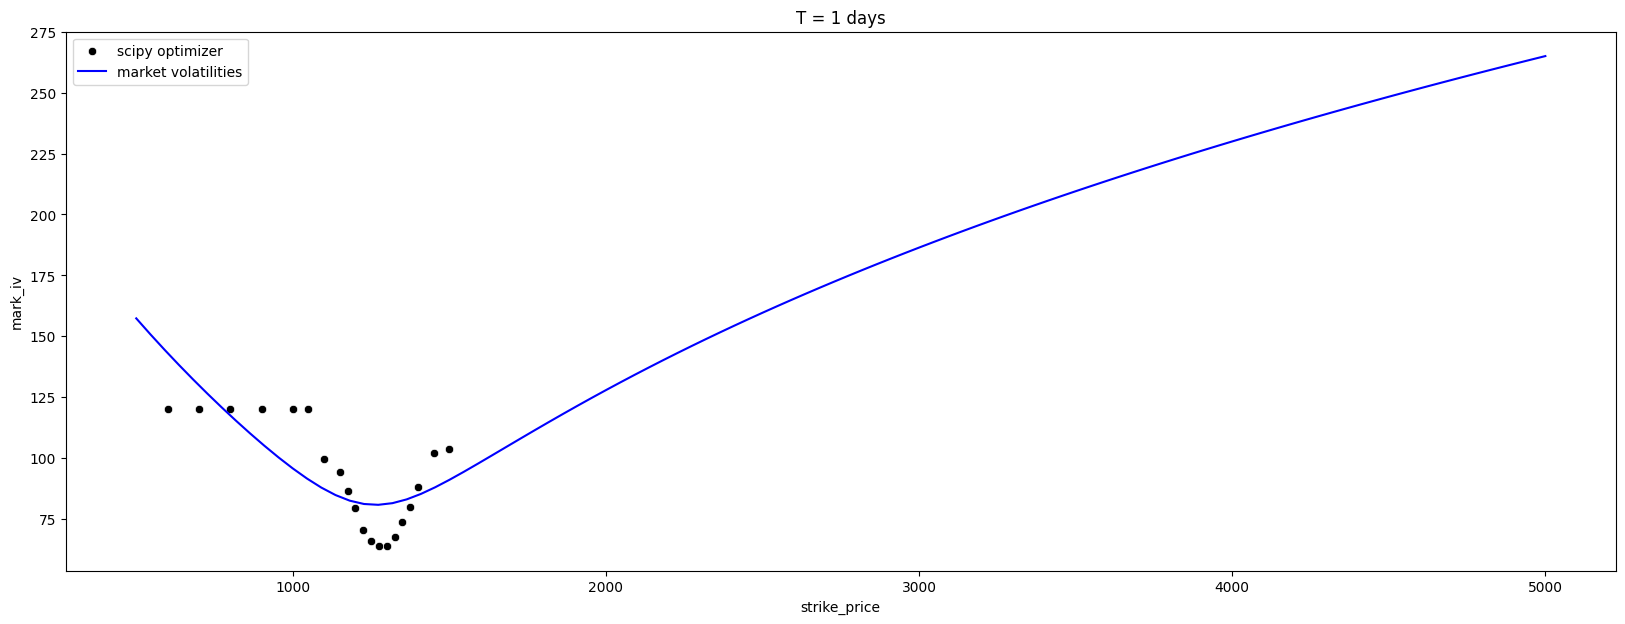

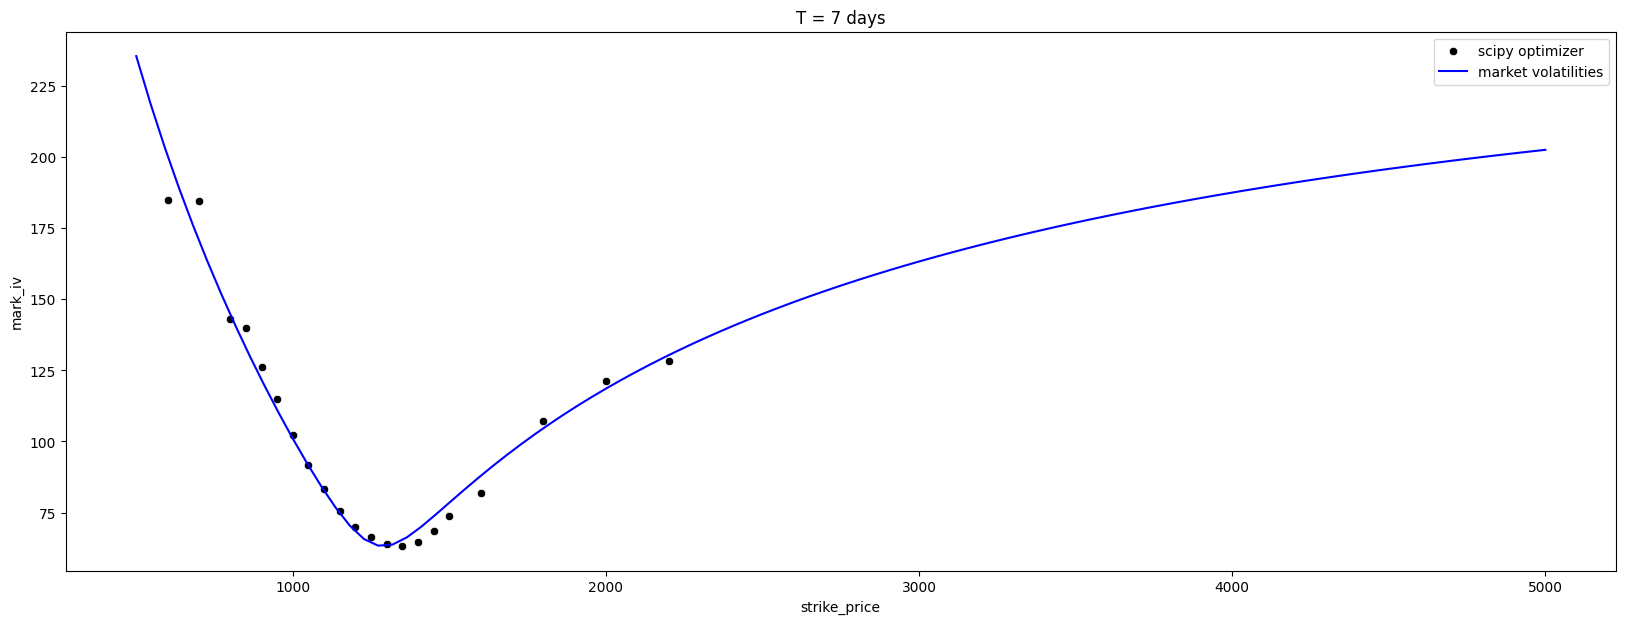

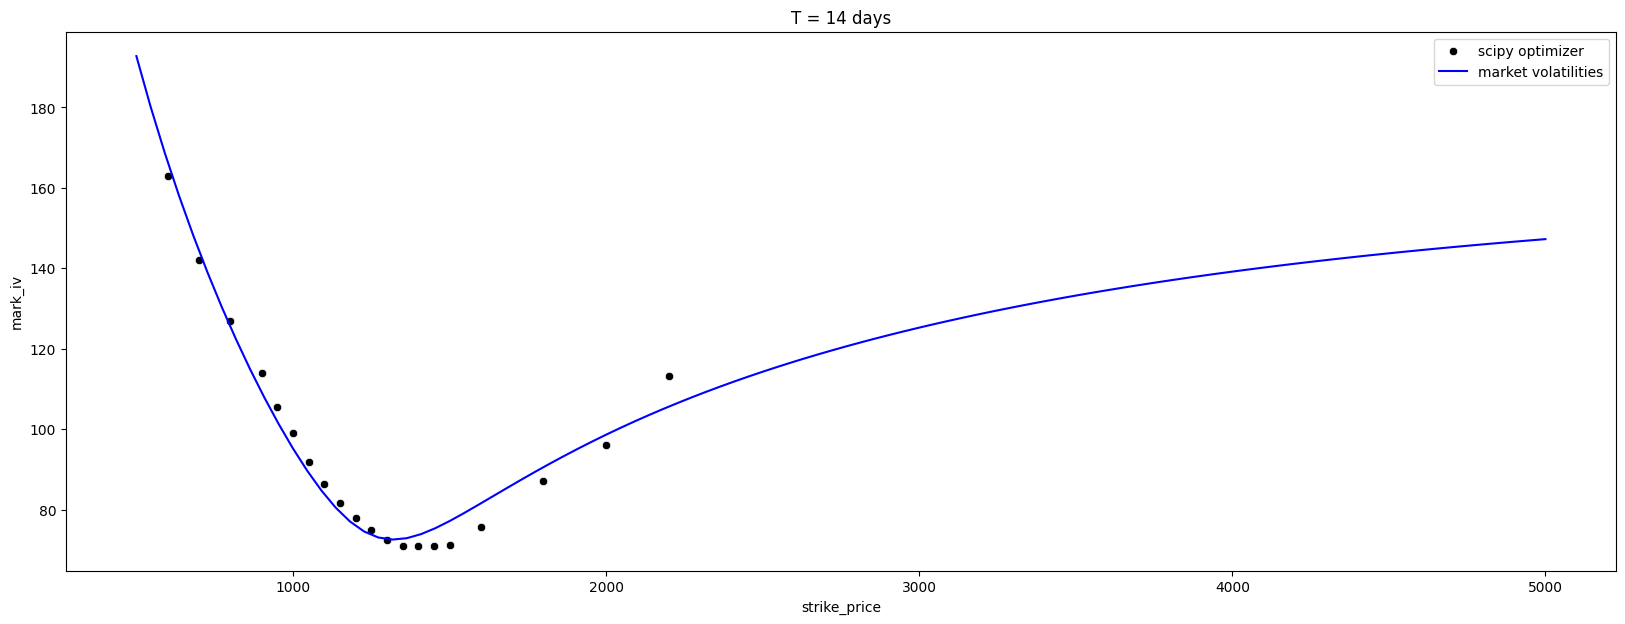

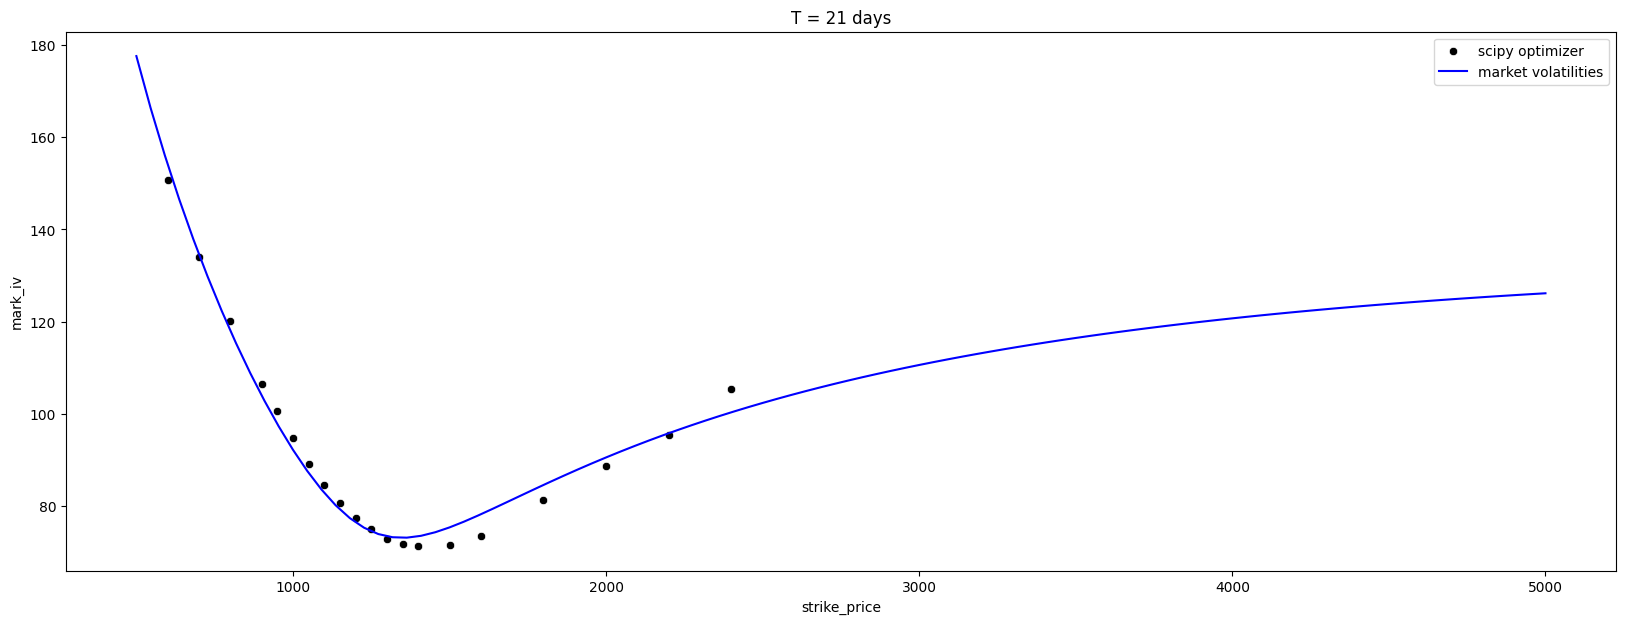

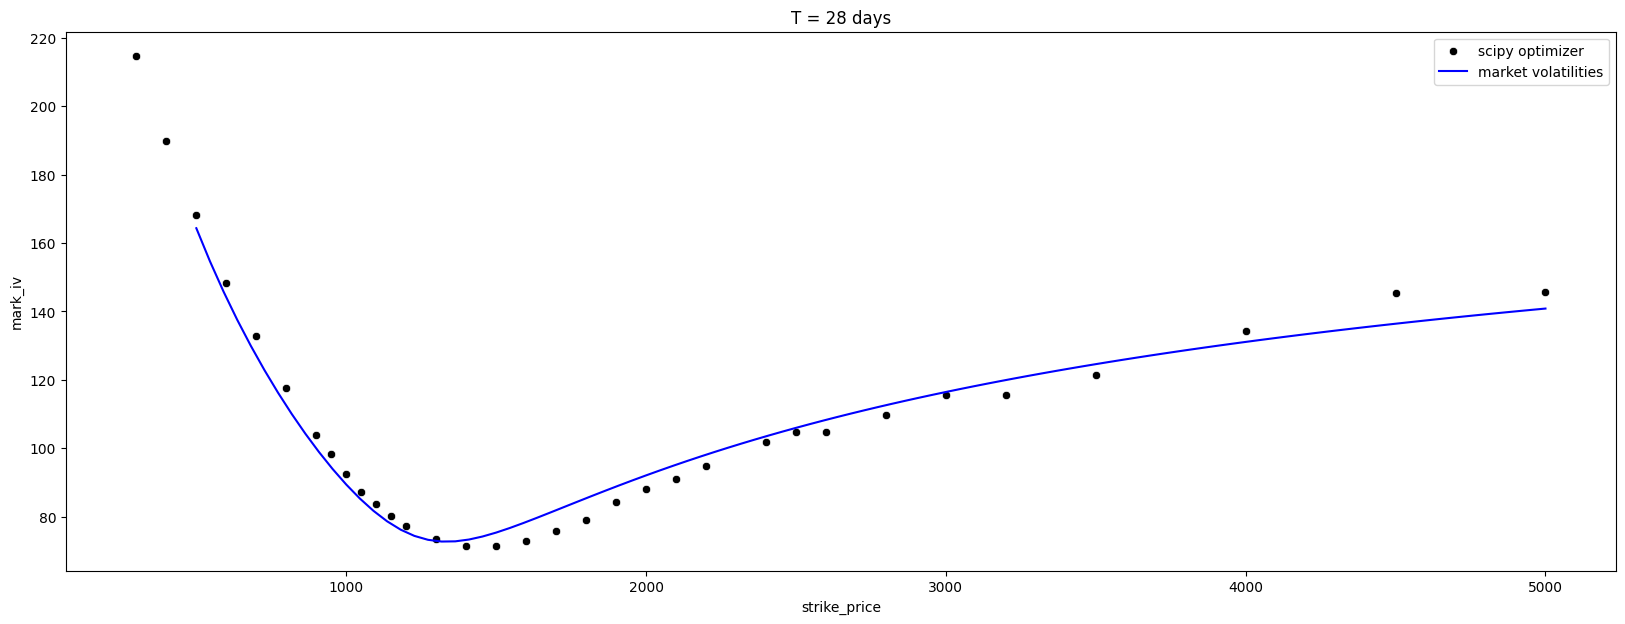

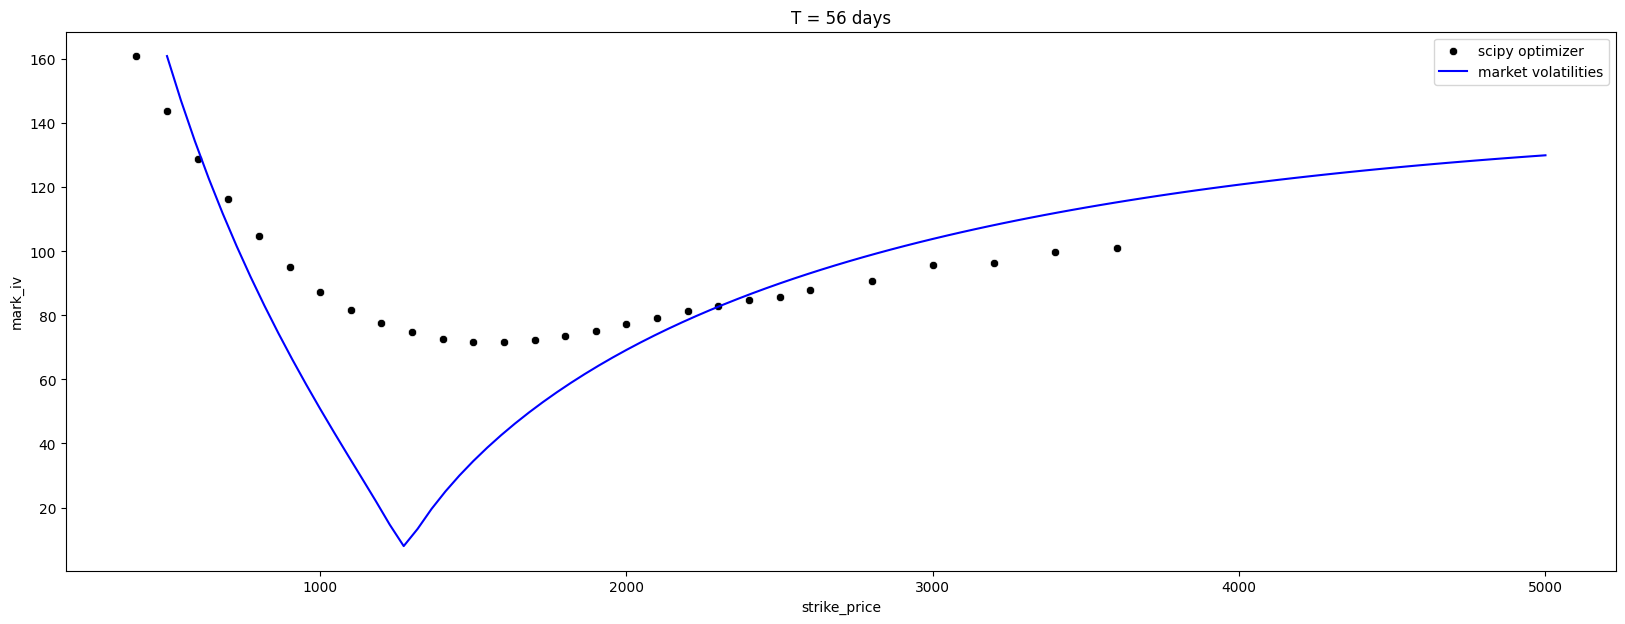

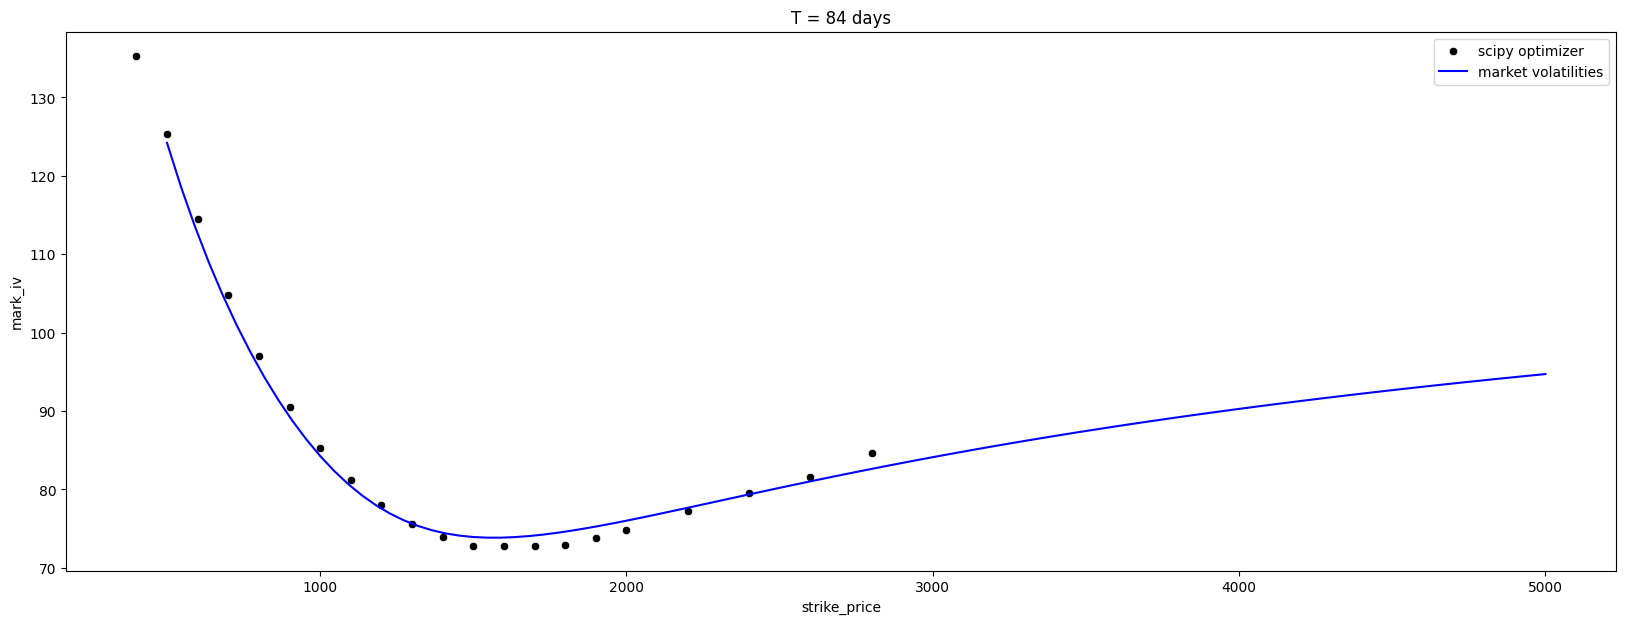

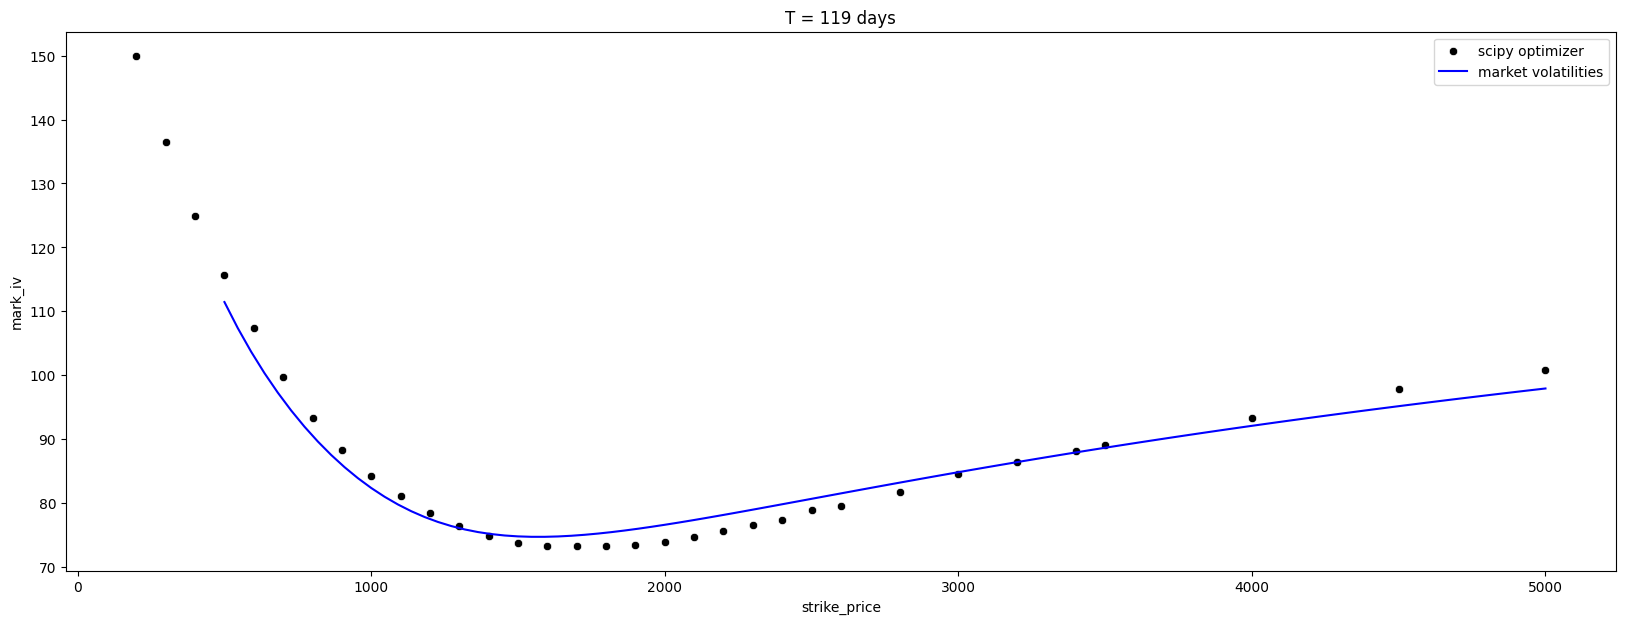

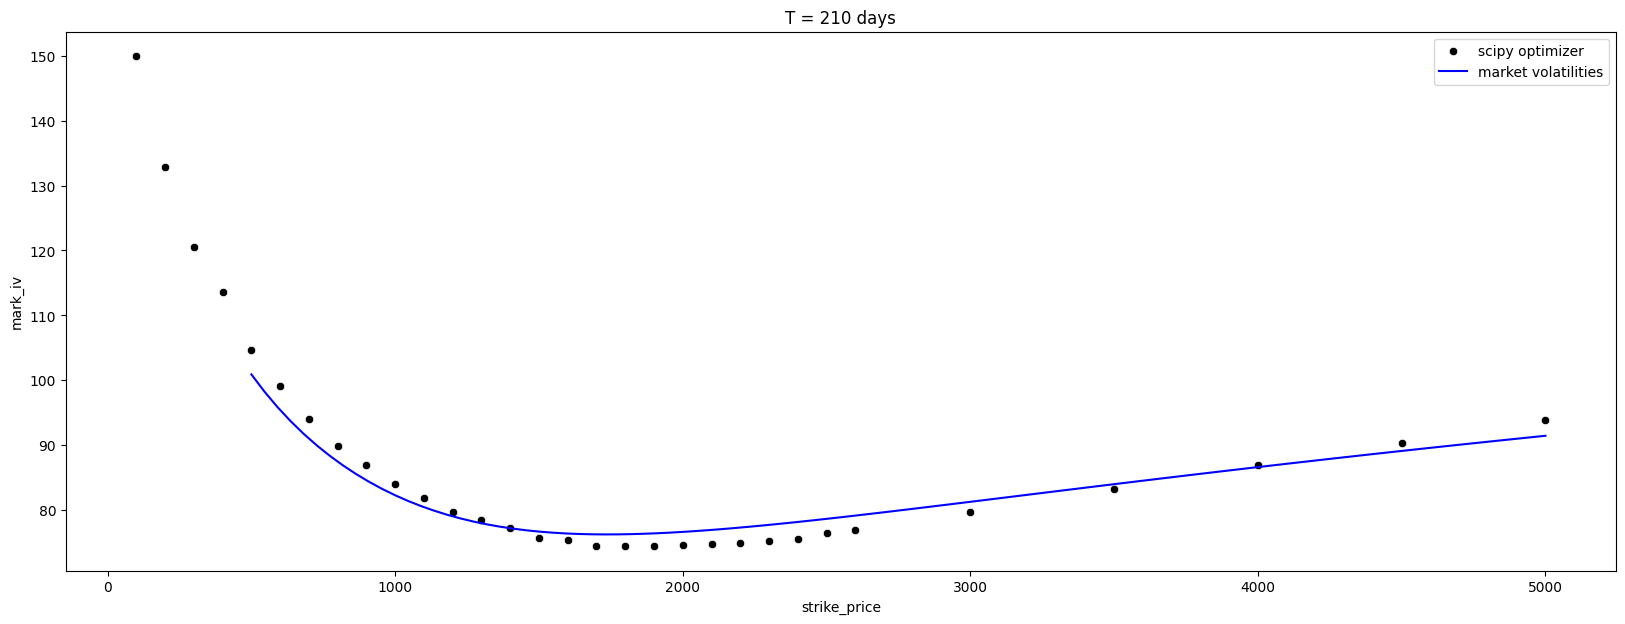

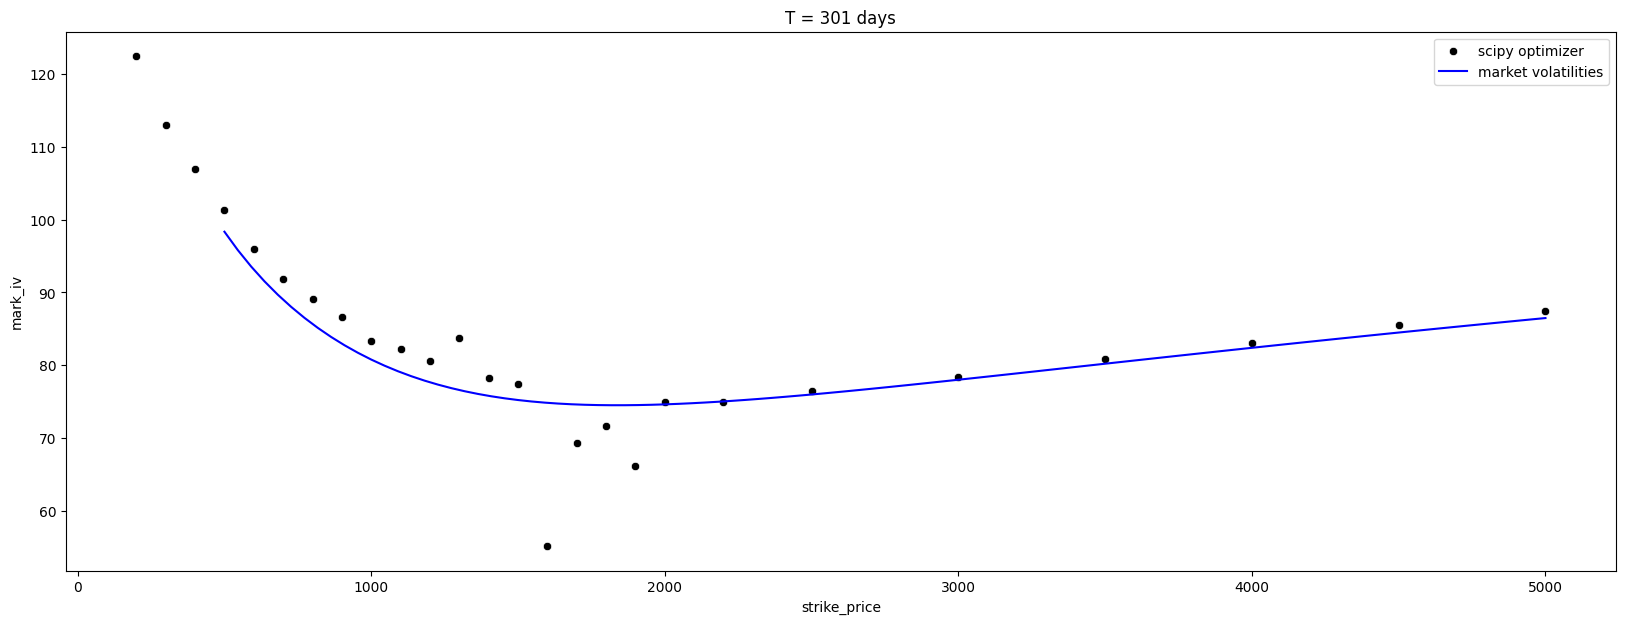

In [177]:
# выкидываем из выборки опционы, которые deep ITM
list_of_vols = []
alphas = []
betas = []
rhos = []
vs = []
Ts = []
for day in days:
    call_ = call[call.days == day]
    put_ = put[put.days == day]
    
    cc = call_[call_["strike_price"]>=call_["underlying_price"]]
    pp = put_[put_["strike_price"]<=put_["underlying_price"]]
    dff = pd.concat([cc, pp])
    dff = dff[dff["strike_price"]<=5000]
    
    sabr = SABR(dff)
#     sabr = SABR(cc)
    vols, alpha, beta, rho, v, T = sabr.run()
    list_of_vols.append(vols)
    alphas.append(alpha)
    betas.append(beta)
    rhos.append(rho)
    vs.append(v)
    Ts.append(T)

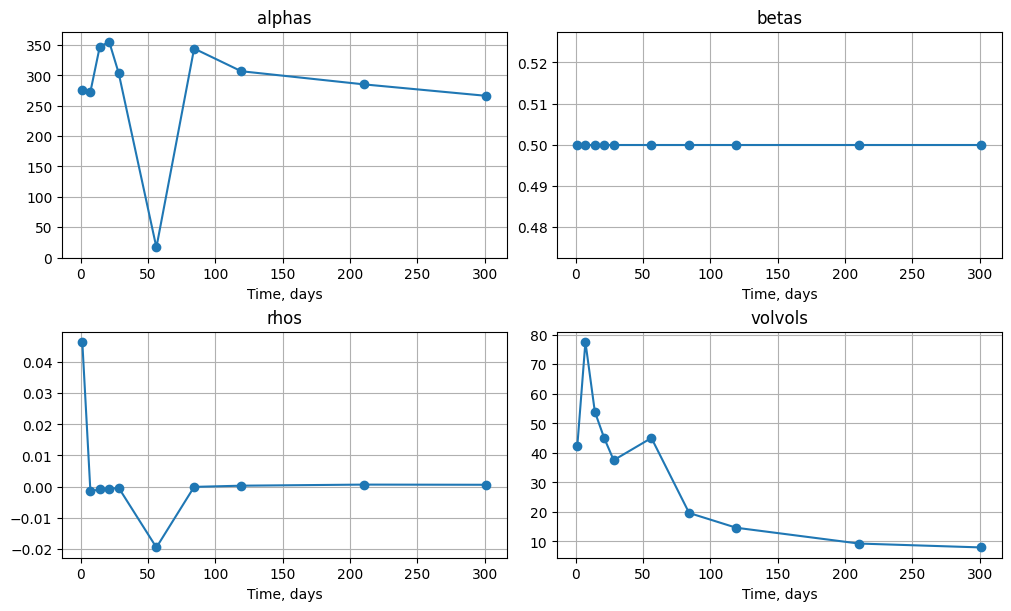

In [178]:
Ts_days = np.array(Ts)*365
fig, axs = plt.subplots(2, 2, figsize=(10, 6), constrained_layout=True)
x_axis_name = 'Time, days'
axs[0, 0].plot(Ts_days, alphas, 'o', ls='-')
axs[0, 0].set_xlabel(x_axis_name)
axs[0, 0].set_title("alphas")
axs[0, 0].grid()

axs[0, 1].plot(Ts_days, betas, 'o', ls='-')
axs[0, 1].set_xlabel(x_axis_name)
axs[0, 1].set_title("betas")
axs[0, 1].grid()

axs[1, 0].plot(Ts_days, rhos, 'o', ls='-')
axs[1, 0].set_xlabel(x_axis_name)
axs[1, 0].set_title("rhos")
axs[1, 0].grid()

axs[1, 1].plot(Ts_days, vs, 'o', ls='-')
axs[1, 1].set_xlabel(x_axis_name)
axs[1, 1].set_title("volvols")
axs[1, 1].grid()


In [147]:
x, y, z = np.linspace(500, 5000, 100), days, np.array(list_of_vols)
sh_0, sh_1 = z.shape
fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])

fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True), 
                 )

fig.update_layout(title='Volatility surface', autosize=False,
                  width=1000, height=500,
                  margin=dict(l=65, r=50, b=65, t=90),
                 scene=dict(
        xaxis_title='Strike, $',
        yaxis_title='Maturite, days',
        zaxis_title='Volatility',
    )
                  
                 )
fig.show()